## 第5章决策树-习题

### 习题5.1
根据表5.1所给的训练数据集，利用信息增益比（C4.5算法）生成决策树。

**解答：**  

表5.1 贷款申请样本数据表  

ID | 年龄 | 有工作 | 有自己的房子 | 信贷情况 | 类别
:-: | :-: | :-: | :-: | :-: | :-: 
1 | 青年 | 否 | 否 | 一般 | 否
2 | 青年 | 否 | 否 | 好 | 否
3 | 青年 | 是 | 否 | 好 | 是
4 | 青年 | 是 | 是 | 一般 | 是
5 | 青年 | 否 | 否 | 一般 | 否
6 | 中年 | 否 | 否 | 一般 | 否
7 | 中年 | 否 | 否 | 好 | 否
8 | 中年 | 是 | 是 | 好 | 是
9 | 中年 | 否 | 是 | 非常好 | 是
10 | 中年 | 否 | 是 | 非常好 | 是
11 | 老年 | 否 | 是 | 非常好 | 是
12 | 老年 | 否 | 是 | 好 | 是
13 | 老年 | 是 | 否 | 好 | 是
14 | 老年 | 是 | 否 | 非常好 | 是
15 | 老年 | 否 | 否 | 一般 | 否

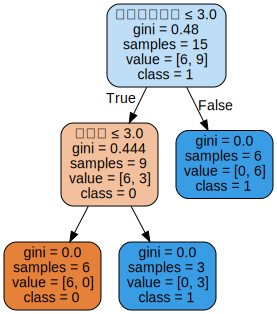

In [1]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import preprocessing
import numpy as np
import pandas as pd

from sklearn import tree
import graphviz

features = ["年龄", "有工作", "有自己的房子", "信贷情况"]
X_train = pd.DataFrame([
    ["青年", "否", "否", "一般"],
    ["青年", "否", "否", "好"],
    ["青年", "是", "否", "好"],
    ["青年", "是", "是", "一般"],
    ["青年", "否", "否", "一般"],
    ["中年", "否", "否", "一般"],
    ["中年", "否", "否", "好"],
    ["中年", "是", "是", "好"],
    ["中年", "否", "是", "非常好"],
    ["中年", "否", "是", "非常好"],
    ["老年", "否", "是", "非常好"],
    ["老年", "否", "是", "好"],
    ["老年", "是", "否", "好"],
    ["老年", "是", "否", "非常好"],
    ["老年", "否", "否", "一般"]
])
y_train = pd.DataFrame(["否", "否", "是", "是", "否", 
                        "否", "否", "是", "是", "是", 
                        "是", "是", "是", "是", "否"])
# 数据预处理
le_x = preprocessing.LabelEncoder()
le_x.fit(np.unique(X_train))
X_train = X_train.apply(le_x.transform)
le_y = preprocessing.LabelEncoder()
le_y.fit(np.unique(y_train))
y_train = y_train.apply(le_y.transform)
# 调用sklearn.DT建立训练模型
model_tree = DecisionTreeClassifier()
model_tree.fit(X_train, y_train)

# 可视化
dot_data = tree.export_graphviz(model_tree, out_file=None,
                                    feature_names=features,
                                    class_names=[str(k) for k in np.unique(y_train)],
                                    filled=True, rounded=True,
                                    special_characters=True)
graph = graphviz.Source(dot_data)
graph

### 习题5.2
&emsp;&emsp;已知如表5.2所示的训练数据，试用平方误差损失准则生成一个二叉回归树。  
表5.2 训练数据表  

| $x_i$ | 1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9 | 10 |  
| - | - | - | - | - | - | - | - | - | - | - |  
| $y_i$ | 4.50 | 4.75 | 4.91 | 5.34 | 5.80 | 7.05 | 7.90 | 8.23 | 8.70 | 9.00

**解答：**  
&emsp;&emsp;决策树的生成就是递归地构建二叉决策树的过程，对回归树用平方误差最小化准则，对分类树用基尼指数（Gini index）最小化准则，进行特征选择，生成二叉树。  
> 算法5.5（最小二乘回归树生成算法）  
输入：训练数据集$D$  
输出：回归树$f(x)$  
在训练数据集所在的输入空间中，递归地将每个区域划分为两个子区域并决定每个子区域上的输出值，构建二叉决策树；  
(1)选择最优切分变量$j$与切分点$s$，求解$$\min_{j,s} \left[ \min_{c_1} \sum_{x_i \in R_1(j,s)} (y_i - c_1)^2 + \min_{c_2} \sum_{x_i \in R_2(j,s)} (y_i - c_2)^2\right]$$遍历变量$j$，对固定的切分变量$j$扫描切分点$s$，选择使得上式达到最小值的对$(j,s)$  
(2)用选定的对$(j,s)$划分区域并决定相应的输出值：$$R_1(j,s)=\{x|x^{(j)}\leqslant s\}, R_2(j,s)=\{x|x^{(j)} > s\} \\ 
\hat{c_m} = \frac{1}{N_m} \sum_{x_i \in R_m(j,s)} y_i, x \in R_m, m=1,2 $$
(3)继续对两个子区域调用步骤(1),(2)，直至满足停止条件  
(4)将输入空间划分为$M$个区域$R_1,R_2,\cdots,R_M$，生成决策树：$$f(x)=\sum_{m=1}^M \hat{c_m} I(x \in R_m)$$

In [2]:
import numpy as np


class LeastSqRTree:
    def __init__(self, train_X, y, epsilon):
        # 训练集特征值
        self.x = train_X
        # 类别
        self.y = y
        # 特征总数
        self.feature_count = train_X.shape[1]
        # 损失阈值
        self.epsilon = epsilon
        # 回归树
        self.tree = None

    def _fit(self, x, y, feature_count, epsilon):
        # 选择最优切分点变量j与切分点s
        (j, s, minval, c1, c2) = self._divide(x, y, feature_count)
        # 初始化树
        tree = {"feature": j, "value": x[s, j], "left": None, "right": None}
        if minval < self.epsilon or len(y[np.where(x[:, j] <= x[s, j])]) <= 1:
            tree["left"] = c1
        else:
            tree["left"] = self._fit(x[np.where(x[:, j] <= x[s, j])], 
                                     y[np.where(x[:, j] <= x[s, j])],
                                     self.feature_count,
                                     self.epsilon)
        if minval < self.epsilon or len(y[np.where(x[:, j] > s)]) <= 1:
            tree["right"] = c2
        else:
            tree["right"] = self._fit(x[np.where(x[:, j] > x[s, j])], 
                                      y[np.where(x[:, j] > x[s, j])],
                                      self.feature_count,
                                      self.epsilon)
        return tree

    def fit(self):
        self.tree = self._fit(self.x, self.y, self.feature_count, self.epsilon)

    @staticmethod
    def _divide(x, y, feature_count):
        # 初始化损失误差
        cost = np.zeros((feature_count, len(x)))
        # 公式5.21
        for i in range(feature_count):
            for k in range(len(x)):
                # k行i列的特征值
                value = x[k, i]
                y1 = y[np.where(x[:, i] <= value)]
                c1 = np.mean(y1)
                y2 = y[np.where(x[:, i] > value)]
                c2 = np.mean(y2)
                y1[:] = y1[:] - c1
                y2[:] = y2[:] - c2
                cost[i, k] = np.sum(y1 * y1) + np.sum(y2 * y2)
        # 选取最优损失误差点
        cost_index = np.where(cost == np.min(cost))
        # 选取第几个特征值
        j = cost_index[0][0]
        # 选取特征值的切分点
        s = cost_index[1][0]
        # 求两个区域的均值c1,c2
        c1 = np.mean(y[np.where(x[:, j] <= x[s, j])])
        c2 = np.mean(y[np.where(x[:, j] > x[s, j])])
        return j, s, cost[cost_index], c1, c2

In [3]:
train_X = np.array([[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]]).T
y = np.array([4.50, 4.75, 4.91, 5.34, 5.80, 7.05, 7.90, 8.23, 8.70, 9.00])

model_tree = LeastSqRTree(train_X, y, .2)
model_tree.fit()
model_tree.tree

E:\Learning_Projects\MyPythonProjects\statistical-learning-method-solutions-manual\venv\lib\site-packages\numpy\core\fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
E:\Learning_Projects\MyPythonProjects\statistical-learning-method-solutions-manual\venv\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


{'feature': 0,
 'value': 5,
 'left': {'feature': 0, 'value': 3, 'left': 4.72, 'right': 5.57},
 'right': {'feature': 0,
  'value': 7,
  'left': {'feature': 0, 'value': 6, 'left': 7.05, 'right': 7.9},
  'right': {'feature': 0, 'value': 8, 'left': 8.23, 'right': 8.85}}}

根据上面程序的输出，可得到用平方误差损失准则生成一个二叉回归树：$$f(x)=\begin{cases}
4.72 & x \le 3\\
5.57 & 3 < x \le 5\\
7.05 & 5 < x \le 6\\
7.9 & 6 < x \le 7 \\
8.23 & 7 < x \le 8\\
8.85 & x > 8\\
\end{cases}$$

### 习题5.3

&emsp;&emsp;证明 CART 剪枝算法中，当$\alpha$确定时，存在唯一的最小子树$T_{\alpha}$使损失函数$C_{\alpha}(T)$最小。

**解答：**  
**第1步：**内部节点是否剪枝只与以该节点为根节点的子树有关。  
剪枝过程：  
计算子树的损失函数：$$C_{\alpha}(T)=C(T)+\alpha$$其中，$\displaystyle C(T) = \sum_{t=1}^{|T|}N_t (1 - \sum_{k=1}^K (\frac{N_{tk}}{N_t})^2)$，$|T|$是叶结点个数，$K$是类别个数。  
有剪枝前子树$T_0$，剪枝后子树$T_1$，满足$C_{\alpha}(T_1) \leqslant C_{\alpha}(T_0)$则进行剪枝。 

----

**第2步（反证法）：**假设当$\alpha$确定时，存在两颗子树$T_1,T_2$都使得损失函数$C_{\alpha}$最小。  
第1种情况：假设被剪枝的子树在同一边，易知其中一个子树会由另一个子树剪枝而得到，故不可能存在两个最优子树，原结论得证。  
第2种情况：假设被剪枝的子树不在同一边，易知被剪枝掉的子树都可以使损失函数$C_{\alpha}$最小，故两颗子树都可以继续剪枝，故不可能存在两个最优子树，原结论得证。

### 习题5.4

&emsp;&emsp;证明 CART 剪枝算法中求出的子树序列$\{T_0,T_1,\cdots,T_n\}$分别是区间$\alpha \in [\alpha_i,\alpha_{i+1})$的最优子树$T_{\alpha}$，这里$i=0,1,\cdots,n,0=\alpha_0 < \alpha_1 < \cdots, \alpha_n < +\infty$。

**解答：**  
原结论可以表述为：将$\alpha$从小增大，$0=\alpha_0<\alpha_1<\cdots<\alpha_n < +\infty$，在每个区间$[\alpha_i,\alpha_{i+1})$中，子树$T_i$是这个区间里最优的。  
**第1步：**易证，当$\alpha=0$时，整棵树$T_0$是最优的，当$\alpha \rightarrow +\infty$时，根结点组成的单结点树（即$T_n$）是最优的。

----

**第2步：**  
&emsp;&emsp;由于每次剪枝剪的都是某个内部结点的子结点，也就是将某个内部结点的所有子结点回退到这个内部结点里，并将这个内部结点作为叶子结点。因此在计算整体的损失函数时，这个内部结点以外的值都没变，只有这个内部结点的局部损失函数改变了，因此本来需要计算全局的损失函数，但现在只需要计算内部结点剪枝前和剪枝后的损失函数。  
从整体树$T_0$开始剪枝，对$T_0$的任意内部结点$t$    
剪枝前的状态：有$|T_t|$个叶子结点，预测误差是$C(T_t)$  
剪枝后的状态：只有本身一个叶子结点，预测误差是$C(t)$
因此剪枝前的以$t$结点为根结点的子树的损失函数是$$C_{\alpha}(T_t) = C(T_t) + \alpha|T_t|$$剪枝后的损失函数是$$C_{\alpha}(t) = C(t) + \alpha$$易得，一定存在一个$\alpha$使得$C_{\alpha}(T_t) = C_{\alpha}(t)$，这个值为$$\alpha=\frac{C(t)-C(T_t)}{|T_t|-1}$$可知，找到$\alpha$即找到了子结点$t$，即完成了剪枝，得到最优子树$T_1$  
根据书中第73页，采用以下公式计算剪枝后整体损失函数减少的程度：$$g(t)=\frac{C(t)-C(T_t)}{|T_t|-1}$$在$T_0$中剪去$g(t)$最小的$T_t$，将得到的子树作为$T_1$，同时将最小的$g(t)$设为$\alpha_1$，$T_1$为区间$[\alpha_1,\alpha_2)$的最优子树。  
依次类推，子树$T_i$是区间$[\alpha_i,\alpha_{i+1})$里最优的，原结论得证。

----

**参考文献：**  
1. MrTriste：https://blog.csdn.net/wjc1182511338/article/details/76793164
2. http://www.pianshen.com/article/1752163397/

----

**讨论：**为什么$\alpha$要取最小的$g(t)$呢？  
<br/><center>
<img style="border-radius: 0.3125em;box-shadow: 0 2px 4px 0 rgba(34,36,38,.12),0 2px 10px 0 rgba(34,36,38,.08);width: 354px;" src="../images/5-1-min-g(t).png"><br><div style="color:orange; border-bottom: 1px solid #d9d9d9;display: inline-block;color: #000;padding: 2px;">图5.1 最小的$g(t)$</div></center>  
&emsp;&emsp;以图中两个点为例，结点1和结点2，$g(t)_2$大于$g(t)_1$，假设在所有结点中$g(t)_1$最小，$g(t)_2$最大，两种选择方法：当选择最大值$g(t)_2$，即结点2进行剪枝，但此时结点1的剪枝前的误差大于剪枝后的误差，即如果不剪枝，误差变大，依次类推，对其它所有的结点的$g(t)$都是如此，从而造成整体的累计误差更大。反之，如果选择最小值$g(t)_1$，即结点1进行剪枝，则其余结点不剪的误差要小于剪枝后的误差，不剪枝为好，且整体的误差最小。从而以最小$g(t)$剪枝获得的子树是该$\alpha$值下的最优子树。